In [1]:
# SETUP:

# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [50]:
import pykeops

In [2]:
# Construct an APD system:
apd1 = apd_system(D=2,
                    ani_thres = 0.8,
                    pixel_size_prefactor = 10)

In [3]:
apd1.N

10

In [4]:
apd1.pixel_params

(310, 310)

In [5]:
apd1.assemble_pixels()

In [6]:
apd1.domain

tensor([[0., 1.],
        [0., 1.]])

(0.0, 1.0)

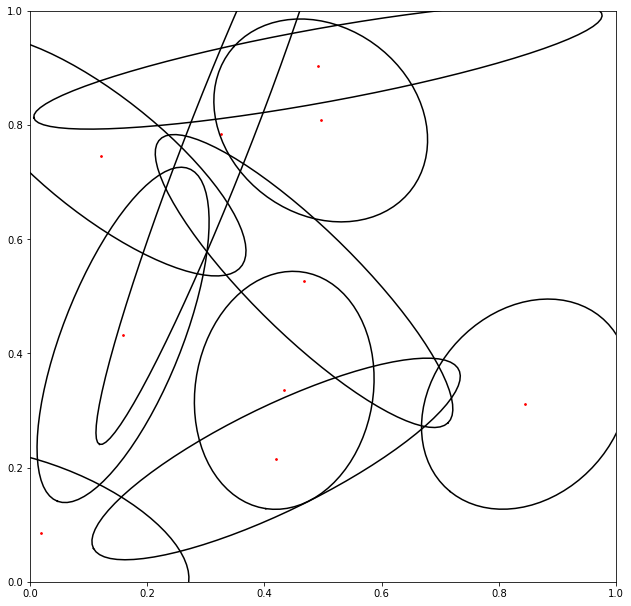

In [7]:
fig, ax = apd1.plot_ellipses()
ax.set_xlim(apd1.domain[0]) 
ax.set_ylim(apd1.domain[1]) 

In [8]:
D_ij = ((apd1.y - apd1.x) | apd1.a.matvecmult(apd1.y - apd1.x)) - apd1.w

In [9]:
D_ij.shape

(10, 96100)

In [10]:
def reconstruct_X_and_A_torch(apd1,i):
    YY = apd1.Y.view(1, torch.prod( torch.tensor( apd1.pixel_params ) ).item(), apd1.D)
    XX = apd1.X.view(apd1.N, 1, apd1.D)
    AA = apd1.As.view(apd1.N, 1, 2,2)
    
    AA_XX_YY = torch.matmul(apd1.As,torch.permute(XX-YY,(0,2,1)))
    XX_YY = (XX-YY)
    weighted_norm = torch.einsum('bcd,bdc->bd', AA_XX_YY, XX_YY)
    pixels0 = (weighted_norm[i,:] < apd1.target_masses[i]/torch.pi)
    pixels1 = pixels0.reshape(apd1.pixel_params).transpose(0,1)
    # first moment
    reconstructed_X = apd1.Y[pixels0].sum(dim=0)/pixels0.sum()
    # second moment
    YY_XX_new = (apd1.Y[pixels0] - reconstructed_X)
    tensor_prod = torch.einsum('bc,bd->bcd', YY_XX_new, YY_XX_new)
    tensor_prod_normalised = 4.0*tensor_prod.sum(dim=0) / (pixels0.sum()) ## the prefactor of 4 is needed but it is a bit of a mystery why...
    reconstructed_A = torch.linalg.inv(tensor_prod_normalised)
    return pixels1, reconstructed_X, reconstructed_A

In [11]:
pixels1, xxx, aaa = reconstruct_X_and_A_torch(apd1,6)

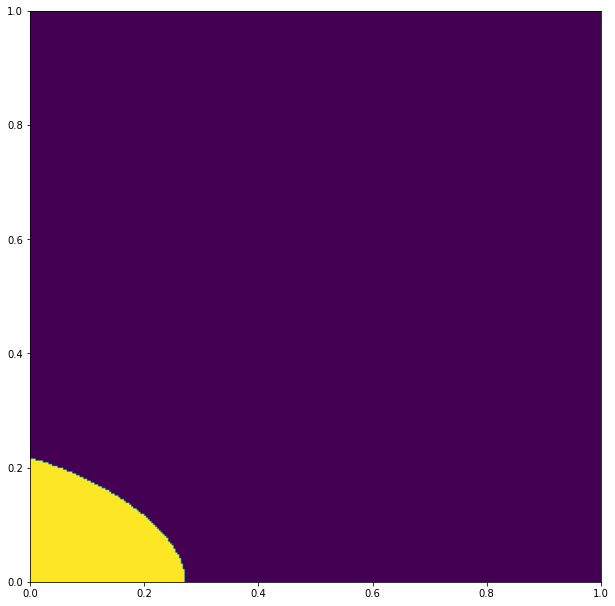

In [12]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10.5, 10.5, forward=True)
ax1.imshow(pixels1, origin='lower', extent = torch.flatten( apd1.domain ).tolist())

In [13]:
decomp = torch.linalg.eigh(aaa)
AB = decomp.eigenvalues**(-0.5)
#scaling = (apd1.target_masses[9]/torch.pi)**(1/2)
scaling = 1.0 #np.sqrt(2.0) # WHY DO WE NEED TO SCALE BY 2 IN PARTICULAR?
AB[0] = AB[0] * scaling
AB[1] = AB[1] * scaling
Rots = decomp.eigenvectors
t = torch.linspace(0, 2*torch.pi, 80)
Ell1 = AB[0,None] @ torch.cos(t)[None,:]
Ell2 = AB[1,None] @ torch.sin(t)[None,:]

Ell = torch.stack([Ell1,Ell2])
Ell = (Ell.transpose(0,1))


Ell_rot = Ell @ Rots

Ell_rot_shifted = Ell_rot + xxx


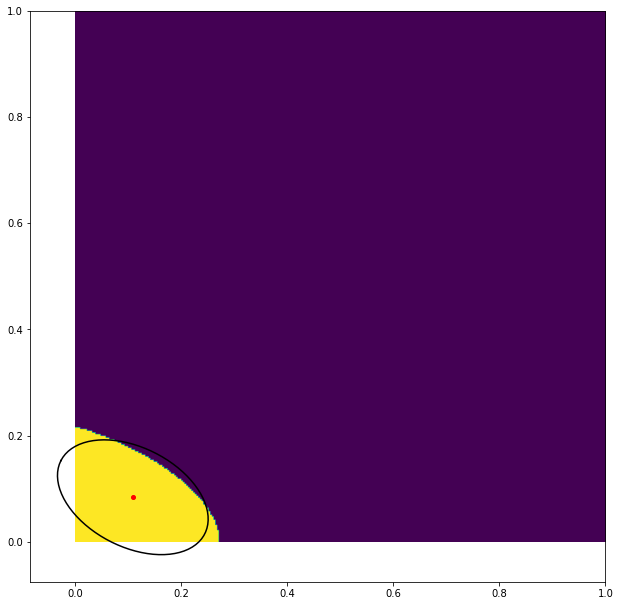

In [14]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10.5, 10.5, forward=True)
ax1.imshow(pixels1, origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.scatter(xxx.cpu()[0],xxx.cpu()[1],c='r',s=16)
ax1.plot(Ell_rot_shifted[:,0],Ell_rot_shifted[:,1],c='k')

In [15]:
def adjust_As(self,backend="auto"):
    if not self.optimality:
        print("Find optimal W first!")
    else:
        D_ij = ((self.y - self.x) | self.a.matvecmult(self.y - self.x)) - self.w
        grain_indices = D_ij.argmin(dim=0,backend=backend).ravel()
        #new_X0 = torch.bincount(grain_indices, self.Y[:,0], minlength = self.N)
        #new_X1 = torch.bincount(grain_indices, self.Y[:,1], minlength = self.N)

        normalisation = torch.bincount(grain_indices,minlength=self.N)
        if self.D == 3:
            new_X2 = torch.bincount(grain_indices,Y[:,2],minlength=N)
            self.X = torch.stack([new_X0/normalisation, new_X1/normalisation,new_X2/normalisation],dim=1)
        else:
            self.X = torch.stack([new_X0/normalisation, new_X1/normalisation],dim=1)

        self.optimality = False
        self.x = LazyTensor(self.X.view(self.N, 1, self.D))

In [16]:
apd1.x

In [63]:
D_ij = ((apd1.y - apd1.x) | apd1.a.matvecmult(apd1.y - apd1.x)) - apd1.w
grain_indices = D_ij.argmin(dim=0,backend='auto').ravel()
X0_new = torch.bincount(grain_indices, apd1.Y[:,0], minlength = apd1.N)
X1_new = torch.bincount(grain_indices, apd1.Y[:,1], minlength = apd1.N)
normalisation = torch.bincount(grain_indices,minlength=apd1.N)

X_new = torch.stack([X0_new/normalisation, X1_new/normalisation],dim=1)

In [65]:
YY = apd1.Y.view(1, torch.prod( torch.tensor( apd1.pixel_params ) ).item(), apd1.D)
XX_new = X_new.view(apd1.N, 1, apd1.D)
#AA = apd1.As.view(apd1.N, 1, 2,2)
    
# AA_XX_YY = torch.matmul(apd1.As,torch.permute(XX-YY,(0,2,1)))
# XX_YY = (XX-YY)
# weighted_norm = torch.einsum('bcd,bdc->bd', AA_XX_YY, XX_YY)

In [87]:
YY_XX_new = apd1.Y - apd1.X[grain_indices]

tensor_prod = torch.einsum('bc,bd->bcd', YY_XX_new, YY_XX_new)

a00 = torch.bincount(grain_indices,tensor_prod[:,0,0],minlength=apd1.N)
a01 = torch.bincount(grain_indices,tensor_prod[:,0,1],minlength=apd1.N)
a11 = torch.bincount(grain_indices,tensor_prod[:,1,1],minlength=apd1.N)
normalisation = torch.bincount(grain_indices,minlength=apd1.N)



torch.Size([96100, 2])

In [97]:
As0_new = torch.stack([4.0*a00/normalisation, 4.0*a01/normalisation],dim=1)
As1_new = torch.stack([4.0*a01/normalisation, 4.0*a11/normalisation],dim=1)
As_new = torch.linalg.inv(torch.stack([As0_new, As1_new],dim=1))

In [102]:
ee,vv = torch.linalg.eigh(As_new)

In [112]:
ratios = ee[:,1] / ee[:,0]
major_axes = torch.sqrt(ratios)
minor_axes = 1/major_axes

ee_normalised = torch.stack([major_axes,minor_axes],dim=1)

In [117]:
vv.mT.shape

torch.Size([10, 2, 2])

In [120]:
ee.shape

torch.Size([10, 2])

In [124]:
torch.diag_embed(ee).shape

torch.Size([10, 2, 2])

In [134]:
As_lol = (vv @ torch.diag_embed(ee_normalised) @ vv.mT.conj())

In [132]:
As_new[0]

tensor([[40.8460350037, 33.3708572388],
        [33.3708572388, 44.0723457336]])

In [136]:
torch.linalg.det(As_lol)

tensor([1.0000003576, 0.9999998808, 1.0000001192, 0.9999997020, 1.0000001192,
        0.9999998212, 0.9999997020, 0.9999998808, 1.0000003576, 1.0000000000])

In [88]:
apd1.As.shape

torch.Size([10, 2, 2])

In [86]:
tensor_prod.shape

torch.Size([96100, 2, 2])

In [ ]:
    # second moment
    YY_XX_new = (apd1.Y[pixels0] - reconstructed_X)
    tensor_prod = torch.einsum('bc,bd->bcd', YY_XX_new, YY_XX_new)
    tensor_prod_normalised = 4.0*tensor_prod.sum(dim=0) / (pixels0.sum()) ## the prefactor of 4 is needed but it is a bit of a mystery why...
    reconstructed_A = torch.linalg.inv(tensor_prod_normalised)

In [69]:
apd1.Y[:,0].shape

torch.Size([96100])

In [67]:
(XX_new - YY).shape

torch.Size([10, 96100, 2])

In [31]:
#YY_XX_new = (apd1.Y[pixels0] - reconstructed_X)
#tensor_prod = torch.einsum('bc,bd->bcd', YY_XX_new, YY_XX_new)
#tensor_prod_normalised = 4.0*tensor_prod.sum(dim=0) / (pixels0.sum()) ## the prefactor of 4 is needed but it is a bit of a mystery why...
#reconstructed_A = torch.linalg.inv(tensor_prod_normalised)


torch.bincount(grain_indices,apd1.Y[:,0])

RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

In [34]:
new_X0

tensor([ 3796.0346679688,   836.8237915039,  6201.7690429688,  8870.2246093750,
         1320.7379150391,  3576.2512207031,   537.2933349609,  1128.1520996094,
        18383.9941406250,  3399.0915527344])

In [137]:
apd1.a

In [36]:
apd1.Y - new_X

RuntimeError: The size of tensor a (96100) must match the size of tensor b (10) at non-singleton dimension 0

In [43]:
lol1 = apd1.y - apd1.x
lol1.shape
lol1[:,:,0].shape

(10, 96100)

In [40]:
grain_indices.shape

torch.Size([96100])

In [44]:
grain_indices

tensor([6, 6, 6,  ..., 2, 2, 2])

In [46]:
?centroids

Object `centroids` not found.


In [61]:
new_X.shape

torch.Size([10, 2])

In [138]:
apd1.domain[0]

tensor([0., 1.])